## Notebook for pytorch computer vision exercises
https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises

1. Load the `torchvision.datasets.MNIST()` train and test datasets.

In [1]:
from sympy.functions.elementary.tests.test_trigonometric import nn
from torchvision.datasets import MNIST
from torchvision import transforms

train_dataset = MNIST(root='./topography/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./topography/data', train=False, transform=transforms.ToTensor(), download=True)

2. Visualize at least 5 different samples of the MNIST training dataset.

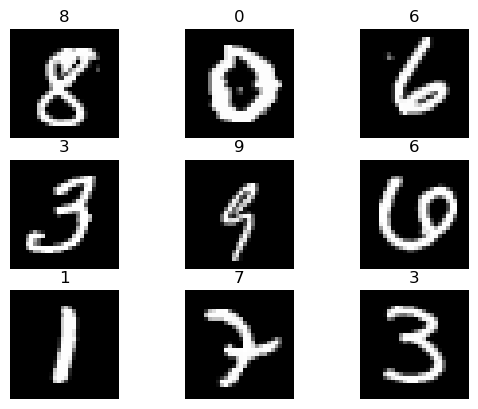

In [2]:
import matplotlib.pyplot as plt
import torch

rows, cols = 3, 3

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    image, label = train_dataset[random_idx]
    plt.subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(label)
    plt.axis(False)

3. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [3]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

4. Recreate model_2 used in this notebook capable of fitting on the MNIST dataset.

In [4]:
class TinyVGG(torch.nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, num_classes: int):
        super().__init__()
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_channels, hidden_units, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_units * 7 * 7, num_classes),
        )

    def forward(self, x):
        return self.block3(self.block2(self.block1(x)))

5. Train the model you built in exercise 4. on CPU and GPU and see how long it takes on each.

In [8]:
import torchmetrics

def train_step(model: torch.nn.Module,
               data: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.functional.cross_entropy,
               device: torch.device):
    model.train()

    for X, y in data:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_step(model: torch.nn.Module,
              data: torch.utils.data.DataLoader,
              device: torch.device) -> torch.Tensor:
    model.eval()
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device=device)
    y_preds = torch.empty(0).to(device=device)
    y_targets = torch.empty(0).to(device=device)
    with torch.inference_mode():
        for X,y in data:
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            yp = torch.softmax(y_logits, dim=1).argmax(dim=1)
            y_preds = torch.cat((y_preds, yp), dim=0)
            y_targets = torch.cat((y_targets, y), dim=0)
    return accuracy(y_preds, y_targets)


In [6]:
from tqdm.notebook import tqdm  # Time to train can be checked in the tqdm data

EPOCHS = 10

cpu_model = TinyVGG(input_channels=1, hidden_units=10, num_classes=10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cpu_model.parameters(), lr=0.01)
for epoch in tqdm(range(EPOCHS)):
    train_step(model=cpu_model, data=train_loader, optimizer=optimizer, loss_fn=loss_fn, device=torch.device('cpu'))
    accuracy = test_step(model=cpu_model, data=test_loader, device=torch.device('cpu'))
    print(f'After the epoch {epoch} test accuracy is {accuracy * 100:.2f}%')


  0%|          | 0/10 [00:00<?, ?it/s]

After the epoch 0 test accuracy is 96.35%
After the epoch 1 test accuracy is 96.91%
After the epoch 2 test accuracy is 97.36%
After the epoch 3 test accuracy is 96.56%
After the epoch 4 test accuracy is 97.31%
After the epoch 5 test accuracy is 96.77%
After the epoch 6 test accuracy is 97.27%
After the epoch 7 test accuracy is 96.91%
After the epoch 8 test accuracy is 97.44%
After the epoch 9 test accuracy is 97.42%


In [9]:
gpu_model = TinyVGG(input_channels=1, hidden_units=10, num_classes=10).to('cuda:0')
optimizer = torch.optim.Adam(gpu_model.parameters(), lr=0.01)
for epoch in tqdm(range(EPOCHS)):
    train_step(model=gpu_model, data=train_loader, optimizer=optimizer, loss_fn=loss_fn, device=torch.device('cuda:0'))
    accuracy = test_step(model=gpu_model, data=test_loader, device=torch.device('cuda:0'))
    print(f'After the epoch {epoch} test accuracy is {accuracy * 100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

After the epoch 0 test accuracy is 97.57%
After the epoch 1 test accuracy is 97.84%
After the epoch 2 test accuracy is 97.84%
After the epoch 3 test accuracy is 96.83%
After the epoch 4 test accuracy is 97.81%
After the epoch 5 test accuracy is 97.73%
After the epoch 6 test accuracy is 97.46%
After the epoch 7 test accuracy is 97.72%
After the epoch 8 test accuracy is 97.77%
After the epoch 9 test accuracy is 97.29%


6. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

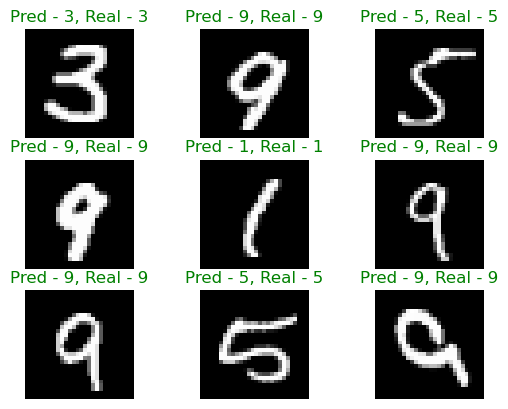

In [16]:
rows, cols = 3, 3

gpu_model.eval()
with torch.inference_mode():
    for i in range(1, rows*cols+1):
        random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
        image, label = train_dataset[random_idx]
        y_logit = gpu_model(image.unsqueeze(0).to('cuda:0'))
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1).item()
        plt.subplot(rows, cols, i)
        plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
        if y_pred == label:
            plt.title(f'Pred - {y_pred}, Real - {label}', color='green')
        else:
            plt.title(f'Pred - {y_pred}, Real - {label}', color='red')
        plt.axis(False)

7. Plot a confusion matrix comparing your model's predictions to the truth labels.

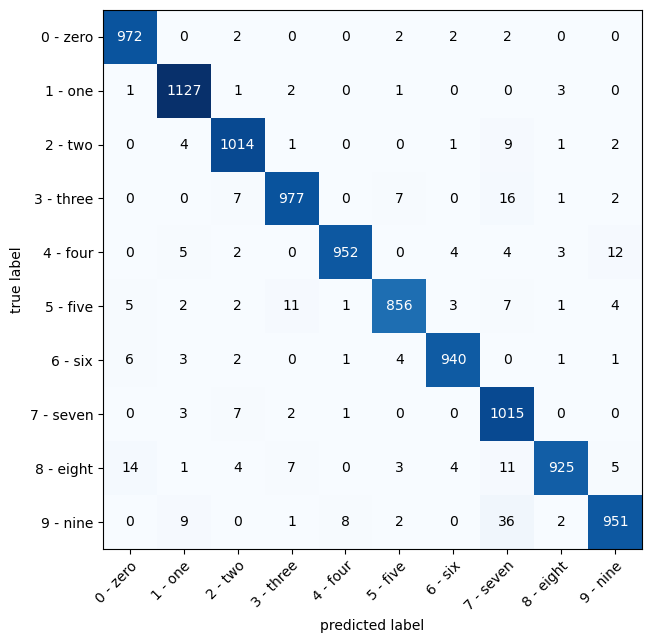

In [17]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = torch.empty(0).to(device='cuda:0')
with torch.inference_mode():
    for X,y in test_loader:
        X, y = X.to(torch.device('cuda:0')), y.to(torch.device('cuda:0'))
        y_logits = gpu_model(X)
        yp = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_preds = torch.cat((y_preds, yp), dim=0)

confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(preds=y_preds.to('cpu'),
                         target=test_dataset.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=test_dataset.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);
